In [1]:
!pip uninstall transformers -y
!pip install git+https://github.com/huggingface/transformers
!pip install joypy
!pip install cityscapesscripts
!pip install evaluate

Found existing installation: transformers 5.0.0.dev0
Uninstalling transformers-5.0.0.dev0:
  Successfully uninstalled transformers-5.0.0.dev0
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-fd1h5ls9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-fd1h5ls9
  Resolved https://github.com/huggingface/transformers to commit 40dc11cd3eb4126652aa41ef8272525affd4a636
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=10906480 sha256=0634bd421903befcaf2a059a06fa1e24917f16a7ae8b415e57a0b2582f0bc759
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ta1c_uv/wheels/49/a7/50/c9fdabbf10e51bb1256adb0c1a587fedd7184f5bad28d47fe3
Successfully built transformers
ERROR: pip's dependency resolver does not currently take into account all the

In [2]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# Hugging Face Transformers
from transformers import Sam3Processor, Sam3Model

In [3]:
# If your dataset is on Drive, mount and point ROOT there
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from pathlib import Path
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/cityscapes")
CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")

In [5]:
OUTPUT_DIR_NAME = "sam3_boundary"

# Device configuration
DEVICE = device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
THIN_CLASS_PROMPTS = {
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "traffic sign",
    11: "person",
    12: "rider",
    17: "motorcycle",
    18: "bicycle",
}

In [7]:
def load_sam3_model():
    print(f"Loading SAM3 model on {DEVICE}...")
    model = Sam3Model.from_pretrained("facebook/sam3").to(DEVICE)
    processor = Sam3Processor.from_pretrained("facebook/sam3")
    model.eval()
    return model, processor

In [8]:
@torch.no_grad()
def generate_thin_boundary_map(image, model, processor):
    """
    1. Computes SAM3 vision embedding ONCE.
    2. Loops through only the THIN class prompts.
    3. Extracts edges from the resulting masks.
    4. Combines them into a single binary boundary map.
    """
    w, h = image.size

    # Final boundary accumulator (binary)
    combined_boundary = np.zeros((h, w), dtype=np.uint8)

    # 1. Pre-compute vision embeddings (Efficient Single-Image Multi-Prompt)
    img_inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    vision_embeds = model.get_vision_features(pixel_values=img_inputs.pixel_values)

    # 2. Iterate only through the classes we care about
    for train_id, text_prompt in THIN_CLASS_PROMPTS.items():

        # Prepare text inputs
        text_inputs = processor(text=text_prompt, return_tensors="pt").to(DEVICE)

        # Run SAM3 Decoder with pre-computed vision features
        outputs = model(
            vision_embeds=vision_embeds,
            input_ids=text_inputs.input_ids,
            attention_mask=text_inputs.attention_mask,
        )

        # Post-process to get binary masks
        # Note: SAM3 might find multiple instances (e.g., 5 poles)
        results = processor.post_process_instance_segmentation(
            outputs,
            threshold=0.4,       # Confidence threshold
            mask_threshold=0.5,  # Pixel probability threshold
            target_sizes=img_inputs.get("original_sizes").tolist()
        )[0]

        masks = results["masks"] # (N, H, W) binary numpy array usually, or tensor

        # If nothing found for this class, skip
        if len(masks) == 0:
            continue

        # Convert to numpy if it's a tensor
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()

        # Collapse all instances of this class into one mask (Logical OR)
        # e.g., combine all 5 poles into one "pole mask"
        class_mask = np.any(masks, axis=0).astype(np.uint8)

        # 3. Extract Boundaries (Canny)
        # We run Canny on the mask itself to get the outline
        edges = cv2.Canny(class_mask * 255, 100, 200)

        # Accumulate
        combined_boundary |= (edges > 0)

    # 4. Optional: Slight dilation
    # Makes the line thickness ~3px, easier for the model to learn than 1px
    kernel = np.ones((3,3), np.uint8)
    dilated_boundary = cv2.dilate(combined_boundary, kernel, iterations=1)

    return dilated_boundary.astype(bool)

In [8]:
from huggingface_hub import login
try:
    login()
except Exception as e:
    print(f"Hugging Face login failed: {e}. Please ensure you have set up your HF_TOKEN.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
model, processor = load_sam3_model()

Loading SAM3 model on cuda...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

In [10]:

# Setup paths
root = Path(CITYSCAPES_ROOT)

# Handle potential nested structure (common in Cityscapes downloads)
if (root / "leftImg8bit_trainvaltest" / "leftImg8bit").exists():
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit"
else:
    img_dir = root / "leftImg8bit"

out_dir = root / OUTPUT_DIR_NAME

print(f"Images directory: {img_dir}")
print(f"Output directory: {out_dir}")

# We process train and val splits
splits = ["train", "val"]

# Find all images
image_paths = []
for split in splits:
    # Search pattern: img_dir/split/city/*.png
    search_pattern = str(img_dir / split / "*" / "*_leftImg8bit.png")
    found = glob.glob(search_pattern)
    image_paths.extend(found)

print(f"Found {len(image_paths)} images. Starting generation...")

# Process Loop
for img_path_str in tqdm(image_paths, desc="SAM3 Boundaries"):
    img_path = Path(img_path_str)

    # Define Save Path
    # Structure: sam3_boundary/train/city/file.npy
    # We want to preserve the structure relative to the split folder
    # img_path: .../leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
    # relative: train/aachen/aachen_000000_000019_leftImg8bit.png
    try:
        relative_path = img_path.relative_to(img_dir)
    except ValueError:
        continue

    save_path = out_dir / relative_path.parent / (img_path.stem + ".npy")

    if save_path.exists():
        continue

    save_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        image = Image.open(img_path).convert("RGB")

        boundary_map = generate_thin_boundary_map(image, model, processor)

        np.save(save_path, boundary_map)

    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")
        continue

Images directory: /content/drive/MyDrive/UCLA/Datasets/cityscapes/leftImg8bit_trainvaltest/leftImg8bit
Output directory: /content/drive/MyDrive/UCLA/Datasets/cityscapes/sam3_boundary
Found 3475 images. Starting generation...


SAM3 Boundaries: 100%|██████████| 3475/3475 [00:18<00:00, 186.14it/s]


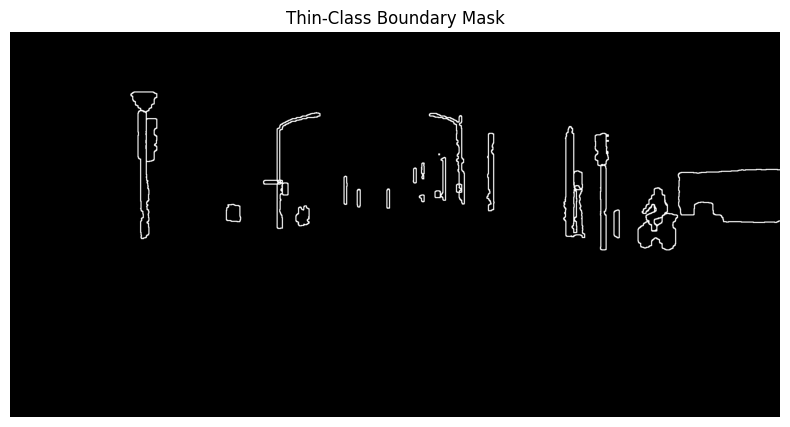

In [19]:
import matplotlib.pyplot as plt

# Load a sample you just generated
boundary = np.load(CITYSCAPES_ROOT / "sam3_boundary/train/zurich/zurich_000121_000019_leftImg8bit.npy")

# Visualize
plt.figure(figsize=(10, 5))
plt.title("Thin-Class Boundary Mask")
plt.imshow(boundary, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
# @title 4. Define Dataset (Corrected for your folder structure)
import torch
import numpy as np
import cv2
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class CityscapesSAM3Dataset(Dataset):
    def __init__(self, root_dir, split="train", feature_extractor=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.feature_extractor = feature_extractor

        # 1. Paths (using your corrected structure)
        self.img_dir = self.root_dir / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
        self.lbl_dir = self.root_dir / "gtFine_trainvaltest" / "gtFine" / split
        self.bnd_dir = self.root_dir / "sam3_boundary" / split

        self.items = []

        # Walk directories
        if not self.img_dir.exists():
            raise FileNotFoundError(f"❌ Path not found: {self.img_dir}")

        for city_folder in self.img_dir.glob("*"):
            if not city_folder.is_dir(): continue
            for img_file in city_folder.glob("*_leftImg8bit.png"):
                base_name = img_file.name.replace("_leftImg8bit.png", "")
                self.items.append({
                    "img": img_file,
                    "lbl": self.lbl_dir / city_folder.name / f"{base_name}_gtFine_labelIds.png",
                    "bnd": self.bnd_dir / city_folder.name / f"{base_name}_leftImg8bit.npy"
                })

        # 2. Define Mapping: Raw Cityscapes ID -> Train ID (0-18)
        # 255 is the "ignore" index
        self.id_to_trainid = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
            19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
            26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self): return len(self.items)

    def encode_target(self, mask):
        # Efficiently map labels using numpy
        mask = np.array(mask)
        label_mask = np.full_like(mask, 255) # Fill with ignore index
        for k, v in self.id_to_trainid.items():
            label_mask[mask == k] = v
        return label_mask

    def __getitem__(self, idx):
        item = self.items[idx]
        image = Image.open(item["img"]).convert("RGB")
        label = Image.open(item["lbl"]) # Raw IDs (0-33)

        # Load Boundary
        if item["bnd"].exists():
            boundary = np.load(item["bnd"])
        else:
            boundary = np.zeros(label.size[::-1], dtype=np.uint8)

        # --- CRITICAL FIX: MAP LABELS ---
        label_mapped = self.encode_target(label)
        # --------------------------------

        encoded = self.feature_extractor(
            images=image,
            segmentation_maps=Image.fromarray(label_mapped),
            return_tensors="pt"
        )

        pixel_values = encoded.pixel_values.squeeze(0)
        labels = encoded.labels.squeeze(0)

        # Resize boundary
        h, w = labels.shape
        boundary_resized = cv2.resize(boundary.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "sam3_boundary": torch.from_numpy(boundary_resized).long()
        }

In [12]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
class SegFormerWithBoundary(nn.Module):
    def __init__(self, num_classes=19, pretrained="nvidia/segformer-b1-finetuned-cityscapes-1024-1024"):
        super().__init__()
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            pretrained, num_labels=num_classes,
            ignore_mismatched_sizes=True, output_hidden_states=True
        )
        self.boundary_head = nn.Sequential(
            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, pixel_values, labels=None, boundary_targets=None):
        outputs = self.segformer(pixel_values, labels=labels, output_hidden_states=True)

        decoder_feats = outputs.hidden_states[-1]
        bnd_logits = self.boundary_head(decoder_feats)
        bnd_logits = F.interpolate(bnd_logits, size=pixel_values.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)

        loss = None
        if labels is not None and boundary_targets is not None:
            seg_loss = outputs.loss
            bnd_loss = F.binary_cross_entropy_with_logits(
                bnd_logits, boundary_targets.float(), pos_weight=torch.tensor(5.0).to(pixel_values.device)
            )
            loss = seg_loss + 2.0 * bnd_loss
            return {"loss": loss, "seg_loss": seg_loss, "bnd_loss": bnd_loss, "logits": outputs.logits}

        return {"logits": outputs.logits}

In [43]:
# @title 5. Train
import evaluate
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Hyperparameters
BATCH_SIZE = 8          # Perfect for A100 (80GB). Use 8 for A100 (40GB) or 4 for L4.
EPOCHS = 4
LR = 6e-5                # Learning Rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"

In [85]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
processor.do_reduce_labels = False

train_ds = CityscapesSAM3Dataset(CITYSCAPES_ROOT, "train", processor)
val_ds = CityscapesSAM3Dataset(CITYSCAPES_ROOT, "val", processor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

model = SegFormerWithBoundary().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
metric = evaluate.load("mean_iou")

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:374: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

In [86]:
ckpt = torch.load("segformer_sam3_final_3.pth", map_location=DEVICE)

model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

In [87]:
print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    # Train Loop
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        boundary_targets = batch["sam3_boundary"].to(DEVICE)

        out = model(pixel_values, labels=labels, boundary_targets=boundary_targets)

        out["loss"].backward()
        optimizer.step()

        total_loss += out["loss"].item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

    # # Validation Loop (Simple)
    # model.eval()
    # with torch.no_grad():
    #     for batch in val_loader:
    #         pix = batch["pixel_values"].to(DEVICE)
    #         lbl = batch["labels"].to(DEVICE)

    #         logits = model(pix)["logits"]
    #         upsampled = F.interpolate(logits, size=lbl.shape[-2:], mode="bilinear", align_corners=False)
    #         preds = upsampled.argmax(dim=1)

    #         metric.add_batch(predictions=preds.cpu().numpy(), references=lbl.cpu().numpy())

    # res = metric.compute(num_labels=19, ignore_index=255)
    # print(f"Mean IoU: {res['mean_iou']:.4f}")
    model.eval()
    num_batches = len(val_loader) // 2

    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader)):
            if i >= num_batches:
                break

            pix = batch["pixel_values"].to(DEVICE)
            lbl = batch["labels"].to(DEVICE)

            logits = model(pix)["logits"]
            upsampled = F.interpolate(
                logits, size=lbl.shape[-2:], mode="bilinear", align_corners=False
            )
            preds = upsampled.argmax(dim=1)

            metric.add_batch(
                predictions=preds.cpu().numpy(),
                references=lbl.cpu().numpy()
            )

    res = metric.compute(num_labels=19, ignore_index=255)
    print(f"Mean IoU (half val): {res['mean_iou']:.4f}")

print("Training Complete!")

Starting Training...


Epoch 1:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 1 Loss: 0.3631


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:357: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Mean IoU (half val): 0.7424


Epoch 2:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 2 Loss: 0.3528


0it [00:00, ?it/s]

Mean IoU (half val): 0.7363


Epoch 3:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 3 Loss: 0.3434


0it [00:00, ?it/s]

Mean IoU (half val): 0.7439


Epoch 4:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 4 Loss: 0.3374


0it [00:00, ?it/s]

Mean IoU (half val): 0.7290
Training Complete!


In [88]:
SAVE_PATH = "segformer_sam3_final_4.pth"

# Save the state dictionary (weights only)
torch.save(model.state_dict(), SAVE_PATH)

In [89]:
from pathlib import Path
import shutil

# Filenames
ckpts = [
    SAVE_PATH
]

# Destination directory
dst_dir = CITYSCAPES_ROOT / "trained_models"
dst_dir.mkdir(parents=True, exist_ok=True)

# Copy checkpoints
for ckpt in ckpts:
    src = Path(ckpt)
    dst = dst_dir / ckpt

    if not src.exists():
        print(f"❌ Missing file: {src}")
        continue

    shutil.copy2(src, dst)
    print(f"✅ Copied {src} → {dst}")

print("Done.")


✅ Copied segformer_sam3_final_4.pth → /content/drive/MyDrive/UCLA/Datasets/cityscapes/trained_models/segformer_sam3_final_4.pth
Done.


In [14]:
from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict
from abc import ABC, abstractmethod

import numpy as np
from PIL import Image
import torch

# Cityscapes label definitions
from cityscapesscripts.helpers.labels import labels as CS_LABELS

# -----------------------------------------------------------------------------
# 1. Abstract Base Class for Segmentation Models
# -----------------------------------------------------------------------------
class BaseSegmentationModel(ABC):
    @abstractmethod
    def predict(self, image: Image.Image) -> np.ndarray:
        """
        Run inference on a single image.

        Args:
            image (PIL.Image.Image): Input image in RGB mode.

        Returns:
            np.ndarray: Predicted segmentation mask of shape (H, W).
                        Values should be integer trainIds (0-18).
        """
        pass

In [15]:
class SegFormerSAM3Wrapper(BaseSegmentationModel):
    def __init__(self, checkpoint_path: str, base_model_name: str = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"):
        """
        Args:
            checkpoint_path: Path to the .pth file you just saved.
            base_model_name: The HuggingFace ID used as the backbone.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Loading base model: {base_model_name}...")

        self.processor = SegformerImageProcessor.from_pretrained(base_model_name)
        self.processor.do_reduce_labels = False

        self.model = SegFormerWithBoundary(num_classes=19, pretrained=base_model_name)

        print(f"Loading trained weights from {checkpoint_path}...")
        state_dict = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(state_dict)

        self.model.to(self.device)
        self.model.eval()
        print(f"Model loaded successfully on {self.device}")

    def predict(self, image: Image.Image) -> np.ndarray:
        if image.mode != "RGB":
            image = image.convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            # Forward pass
            outputs = self.model(pixel_values=inputs["pixel_values"])
            logits = outputs["logits"]

            # Upsample logits to original image size (H, W)
            # image.size is (Width, Height), interpolate needs (Height, Width)
            upsampled_logits = F.interpolate(
                logits,
                size=image.size[::-1], # (H, W)
                mode="bilinear",
                align_corners=False,
            )

        # argmax gives the class index (0-18)
        pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
        return pred_seg

CHECKPOINT = CITYSCAPES_ROOT / "trained_models" / "segformer_sam3_final_4.pth"
# Instantiate
# Note: Ensure base_model_name matches what you used in training ("nvidia/mit-b1" or the finetuned one)
current_model = SegFormerSAM3Wrapper(
    checkpoint_path=CHECKPOINT,
    base_model_name="nvidia/segformer-b1-finetuned-cityscapes-1024-1024"
    # base_model_name="nvidia/mit-b1"
)

Loading base model: nvidia/segformer-b1-finetuned-cityscapes-1024-1024...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:374: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

Loading trained weights from /content/drive/MyDrive/UCLA/Datasets/cityscapes/trained_models/segformer_sam3_final_4.pth...
Model loaded successfully on cuda


In [16]:
import requests
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTL0o6GE2daUNcY6klb5kboC3FMcWzTw8aq4w&s"
image = Image.open(requests.get(url, stream=True).raw)

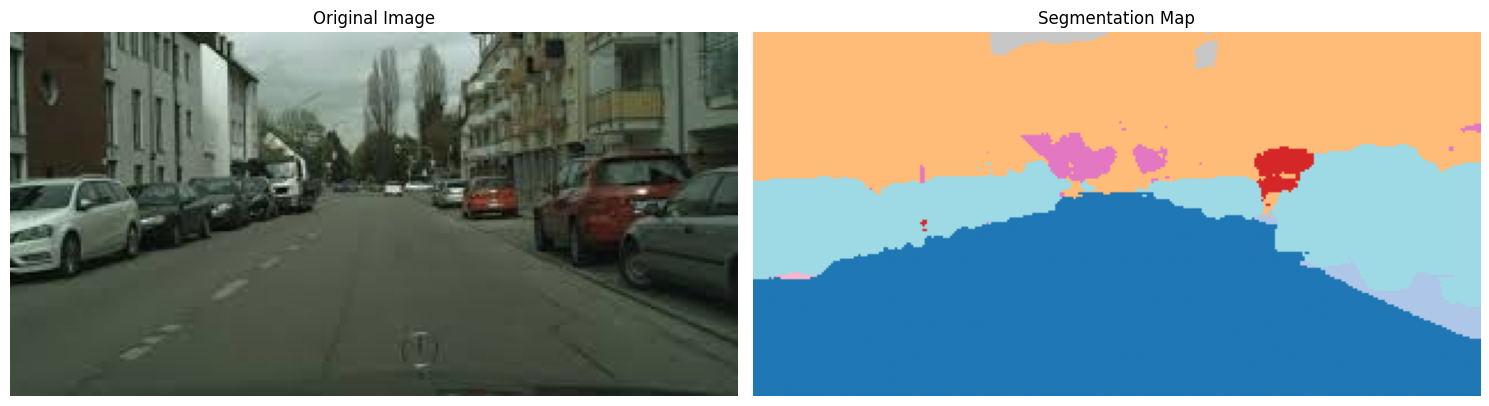

In [17]:
import matplotlib.pyplot as plt

def visualize_segmentation(original_image, segmentation_map):
    plt.figure(figsize=(15, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Plot Segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map, cmap='tab20') # 'tab20' gives distinct colors
    plt.title("Segmentation Map")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

pred_seg = current_model.predict(image)
visualize_segmentation(image, pred_seg)

In [18]:
@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    ignore_in_eval: bool # True for '+' labels / void classes

def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,
            id=lab.id,
            train_id=lab.trainId,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs

CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255

In [19]:

# --- Step 2: Load Cityscapes val split paths in Colab ---

def list_cityscapes_split(root: Path, split: str = "val"):
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    image_paths = sorted(img_dir.rglob("*_leftImg8bit.png"))
    print(f"Found {len(image_paths)} images in split='{split}'")
    return image_paths, gt_dir

val_image_paths, val_gt_dir = list_cityscapes_split(CITYSCAPES_ROOT, split="val")


Found 500 images in split='val'


In [20]:
# --- Step 3: Build a parseable representation (DataFrame) for val ---

import pandas as pd

def make_cityscapes_dataframe(root: Path, split: str = "val") -> pd.DataFrame:
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    records = []
    for img_path in sorted(img_dir.rglob("*_leftImg8bit.png")):
        city = img_path.parent.name
        stem = img_path.name.replace("_leftImg8bit.png", "")

        label_ids = gt_dir / city / f"{stem}_gtFine_labelIds.png"
        instance_ids = gt_dir / city / f"{stem}_gtFine_instanceIds.png"
        color_png = gt_dir / city / f"{stem}_gtFine_color.png"
        polygons_json = gt_dir / city / f"{stem}_gtFine_polygons.json"

        records.append(
            {
                "city": city,
                "image_id": stem,
                "image_path": str(img_path),
                "labelIds_path": str(label_ids),
                "instanceIds_path": str(instance_ids),
                "color_path": str(color_png),
                "polygons_path": str(polygons_json),
            }
        )

    df = pd.DataFrame.from_records(records)
    return df


val_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="val")
print("Total val samples:", len(val_df))
display(val_df.head())


Total val samples: 500


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [23]:
# --- Step 4: Run Inference using the General Model Interface ---

from tqdm.auto import tqdm
import numpy as np

# Define where to save predictions for the current model
# We use the class name to distinguish different models
model_dir_name = current_model.__class__.__name__ + "_preds4"
PRED_ROOT = CITYSCAPES_ROOT / model_dir_name / "val"
PRED_ROOT.mkdir(parents=True, exist_ok=True)


def run_inference_over_df(
    df: pd.DataFrame,
    model: BaseSegmentationModel,
    pred_root: Path,
    overwrite: bool = False,
) -> pd.DataFrame:
    """
    Generic inference loop using BaseSegmentationModel.

    Args:
        df: DataFrame containing image paths.
        model: Instance of BaseSegmentationModel.
        pred_root: Directory to save .npy predictions.
        overwrite: If True, re-run inference even if file exists.
    """
    df = df.copy()
    pred_paths = []

    print(f"Running inference with {model.__class__.__name__}...")
    print(f"Saving results to: {pred_root}")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(row["image_path"])
        image_id = row["image_id"]

        # We'll save as {image_id}_trainIds.npy
        out_path = pred_root / f"{image_id}_trainIds.npy"

        if out_path.exists() and not overwrite:
            pred_paths.append(str(out_path))
            continue

        # Load Image
        img = Image.open(img_path).convert("RGB")

        # Predict using the abstract interface
        pred_trainids = model.predict(img)

        # Save
        np.save(out_path, pred_trainids)
        pred_paths.append(str(out_path))

    df["pred_trainIds_path"] = pred_paths
    return df


# Run inference with the instantiated 'current_model'
val_df_pred = run_inference_over_df(
    val_df,
    model=current_model,
    pred_root=PRED_ROOT,
    overwrite=False,
)

display(val_df_pred.head())

Running inference with SegFormerSAM3Wrapper...
Saving results to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/SegFormerSAM3Wrapper_preds4/val


  0%|          | 0/500 [00:00<?, ?it/s]

,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path,pred_trainIds_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [9]:
def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    return intersection / np.maximum(union, 1)

def evaluate_and_collect(df):
    global_cm = np.zeros((CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES), dtype=np.int64)
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        # load GT + pred
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt = labelIds_to_trainIds_fast(gt)
        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred = np.clip(pred, 0, CITYSCAPES_NUM_CLASSES - 1)

        # mask + flatten
        mask = gt != CITYSCAPES_IGNORE_INDEX
        gt_f = gt[mask].astype(np.int64) # Cast gt_f to int64
        pred_f = pred[mask].astype(np.int64) # Cast pred_f to int64

        idx = np.int64(CITYSCAPES_NUM_CLASSES) * gt_f + pred_f

        # per-image CM
        cm = np.bincount(idx, minlength=CITYSCAPES_NUM_CLASSES**2).reshape(
            CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES
        )

        # add to global CM
        global_cm += cm

        # per-image IoU
        inter = np.diag(cm)
        union = cm.sum(0) + cm.sum(1) - inter
        iou = np.where(union > 0, inter/union, np.nan)

        entry = {
            "image_id": row["image_id"],
            "city": row["city"],
        }
        for tid in CITYSCAPES_EVAL_TRAIN_IDS:
            entry[CITYSCAPES_TRAINID2NAME[tid]] = iou[tid]

        rows.append(entry)

    return global_cm, pd.DataFrame(rows)

In [24]:
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]


# ===============================================
# Fast confusion matrix calculation
# ===============================================
def confusion_matrix_from_df_fast(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # ---- Preload all GTs & predictions to avoid slow disk I/O ----
    gt_list = []
    pred_list = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Loading GT + predictions"):
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt_list.append(labelIds_to_trainIds_fast(gt))

        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred_list.append(np.clip(pred, 0, num_classes - 1))

    # ---- Compute confusion matrix in vectorized form ----
    for gt_train, pred_train in tqdm(zip(gt_list, pred_list), total=len(gt_list),
                                     desc="Computing confusion matrix"):

        mask = gt_train != ignore_index

        gt_flat = gt_train[mask].astype(np.int64)
        pred_flat = pred_train[mask].astype(np.int64)

        idx = num_classes * gt_flat + pred_flat

        cm += np.bincount(
            idx,
            minlength=num_classes * num_classes,
        ).reshape(num_classes, num_classes)

    return cm

In [109]:
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]


# ===============================================
# Fast confusion matrix calculation
# ===============================================
def confusion_matrix_from_df_fast(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # ---- Preload all GTs & predictions to avoid slow disk I/O ----
    gt_list = []
    pred_list = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Loading GT + predictions"):
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt_list.append(labelIds_to_trainIds_fast(gt))

        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred_list.append(np.clip(pred, 0, num_classes - 1))

    # ---- Compute confusion matrix in vectorized form ----
    for gt_train, pred_train in tqdm(zip(gt_list, pred_list), total=len(gt_list),
                                     desc="Computing confusion matrix"):

        mask = gt_train != ignore_index

        gt_flat = gt_train[mask].astype(np.int64)
        pred_flat = pred_train[mask].astype(np.int64)

        idx = num_classes * gt_flat + pred_flat

        cm += np.bincount(
            idx,
            minlength=num_classes * num_classes,
        ).reshape(num_classes, num_classes)

    return cm

In [110]:
!rsync -ah --info=progress2 /content/drive/MyDrive/cityscapes/ /content/cityscapes_local/

rsync: [sender] change_dir "/content/drive/MyDrive/cityscapes" failed: No such file or directory (2)
              0 100%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/0)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


In [111]:
val_df_pred["labelIds_path"] = val_df_pred["labelIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

val_df_pred["pred_trainIds_path"] = val_df_pred["pred_trainIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

In [112]:
global_cm, per_image_iou_df = evaluate_and_collect(val_df_pred)
ious = iou_from_confusion(global_cm)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2253135274.py:35: RuntimeWarning: invalid value encountered in divide
  iou = np.where(union > 0, inter/union, np.nan)


In [113]:
print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

Per-class IoU (Cityscapes 19 eval classes):
 0         road: 98.18%
 1     sidewalk: 85.33%
 2     building: 91.60%
 3         wall: 55.50%
 4        fence: 55.73%
 5         pole: 56.06%
 6 traffic light: 66.53%
 7 traffic sign: 75.37%
 8   vegetation: 92.17%
 9      terrain: 65.74%
10          sky: 94.82%
11       person: 77.08%
12        rider: 52.51%
13          car: 93.94%
14        truck: 78.56%
15          bus: 76.00%
16        train: 43.25%
17   motorcycle: 61.22%
18      bicycle: 73.46%

Mean IoU over 19 classes: 73.32%


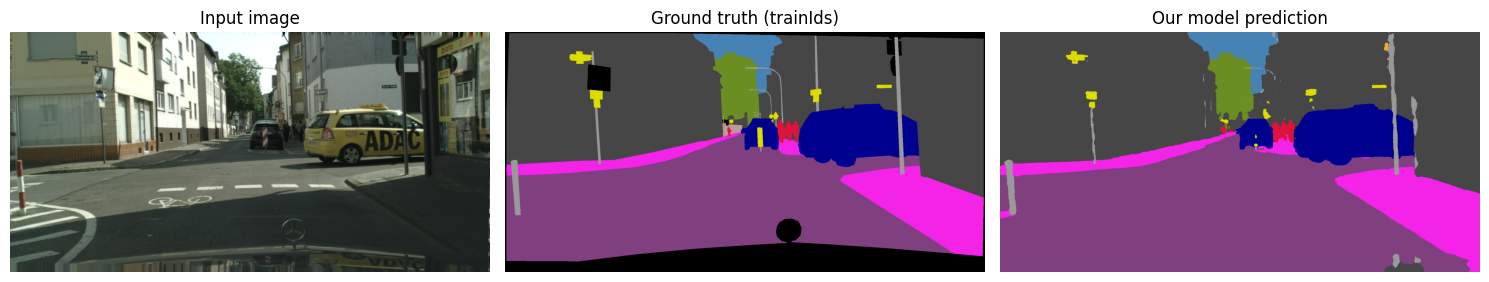

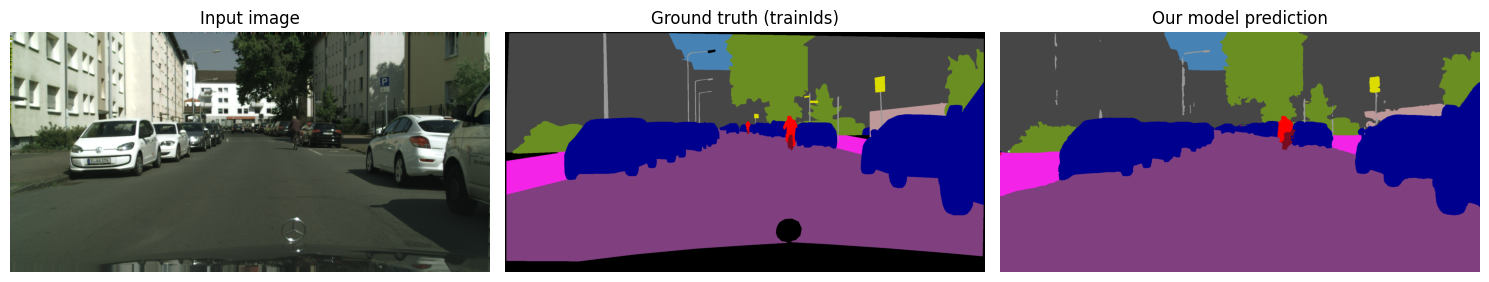

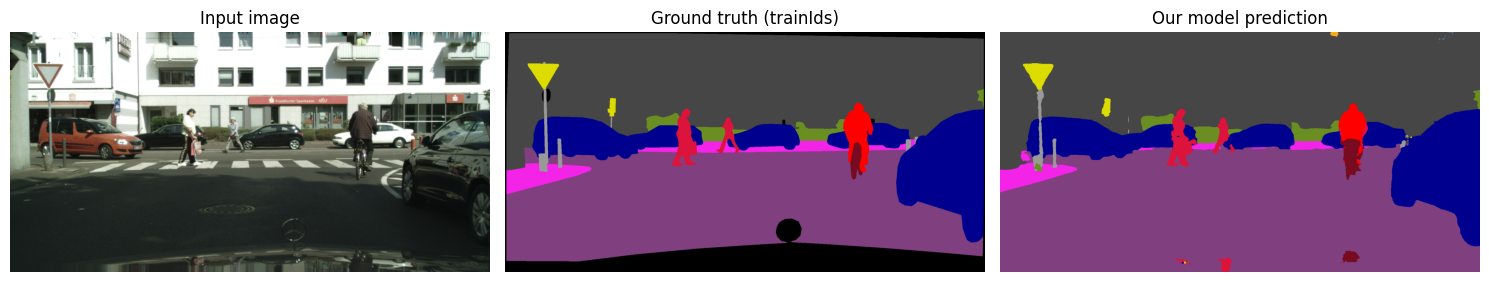

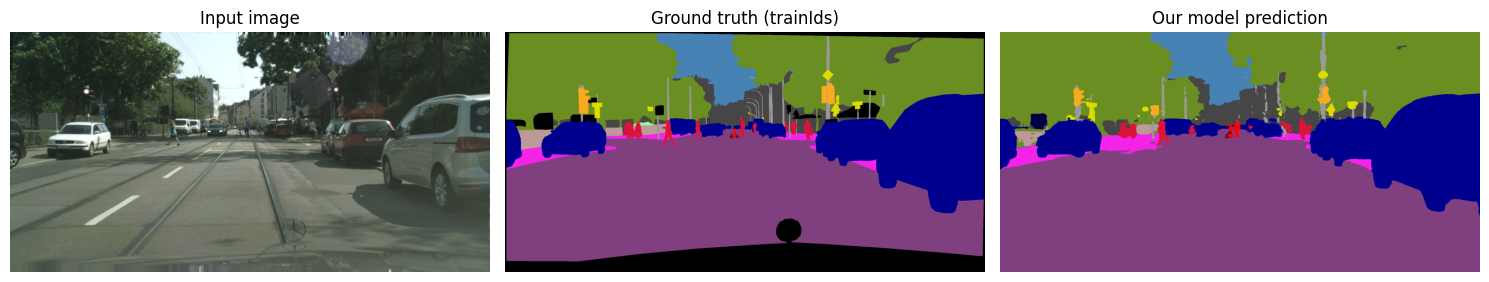

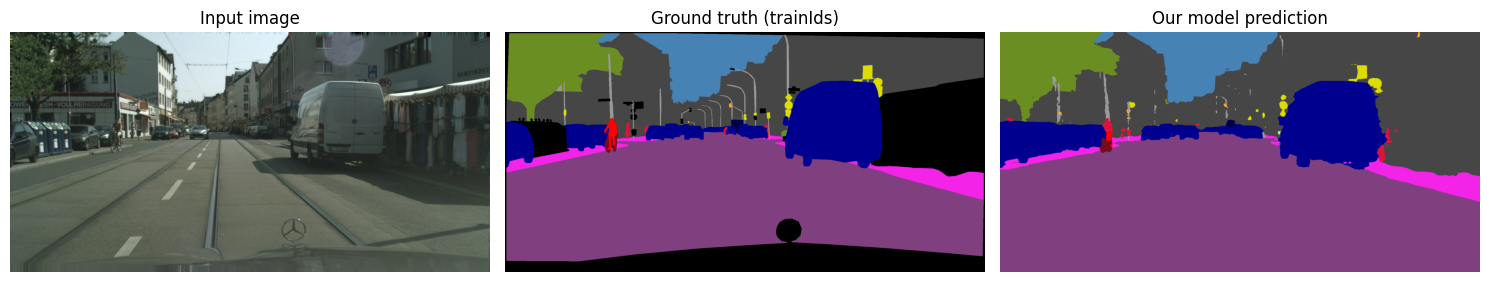

In [27]:
# --- Visualize first few SegFormer inference results (image | GT | prediction) ---

def labelIds_to_trainIds(label_ids: np.ndarray) -> np.ndarray:
    """
    Map Cityscapes labelIds to trainIds using CITYSCAPES_ID2TRAINID.
    255 is used as ignore index.
    """
    train = np.full_like(label_ids, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
    for raw_id, tid in CITYSCAPES_ID2TRAINID.items():
        train[label_ids == raw_id] = np.uint8(tid)
    return train

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from cityscapesscripts.helpers import labels as cs_labels  # already imported as CS_LABELS earlier

# Build a color palette for trainIds using official Cityscapes colors
TRAINID2COLOR = {}
for lab in cs_labels.labels:
    if lab.trainId < 0 or lab.trainId == 255:  # ignore / void
        continue
    TRAINID2COLOR[lab.trainId] = lab.color  # (R, G, B)

def colorize_trainids(trainids: np.ndarray) -> Image.Image:
    """Map trainId mask (H,W) -> RGB PIL.Image using Cityscapes colors."""
    h, w = trainids.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in TRAINID2COLOR.items():
        mask = (trainids == tid)
        color[mask] = rgb
    return Image.fromarray(color)


N_SHOW = 5  # how many examples to visualize
for _, row in val_df_pred.head(N_SHOW).iterrows():
    # Load image
    img = Image.open(row["image_path"]).convert("RGB")

    # Ground-truth: labelIds -> trainIds
    gt_labelids = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
    gt_trainids = labelIds_to_trainIds(gt_labelids)

    # Prediction: saved trainId mask
    pred_trainids = np.load(row["pred_trainIds_path"]).astype(np.uint8)

    # Colorized visualizations
    gt_color = colorize_trainids(gt_trainids)
    pred_color = colorize_trainids(pred_trainids)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Input image")
    axes[0].axis("off")

    axes[1].imshow(gt_color)
    axes[1].set_title("Ground truth (trainIds)")
    axes[1].axis("off")

    axes[2].imshow(pred_color)
    axes[2].set_title("Our model prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [115]:
import joypy
import matplotlib.pyplot as plt
import numpy as np

# Identify class columns
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

# Sort by class difficulty (median IoU)
median_iou = per_image_iou_df[class_cols].median().sort_values()
sorted_classes = median_iou.index.tolist()

# Build clean data: each class has its own filtered 1D array
clean_data = {}
for cls in sorted_classes:
    col = per_image_iou_df[cls]
    # convert strings or invalid entries to NaN
    col = pd.to_numeric(col, errors='coerce')
    # remove NaNs (meaning class absent)
    col = col.dropna()
    clean_data[cls] = col.values

In [116]:
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

long_df = (
    per_image_iou_df[class_cols]
    .melt(var_name='category', value_name='IoU')
    .dropna()
)

# drop NaNs (class not present in image) )
plot_df = long_df[long_df["IoU"] > 0]

<Figure size 1000x1200 with 0 Axes>

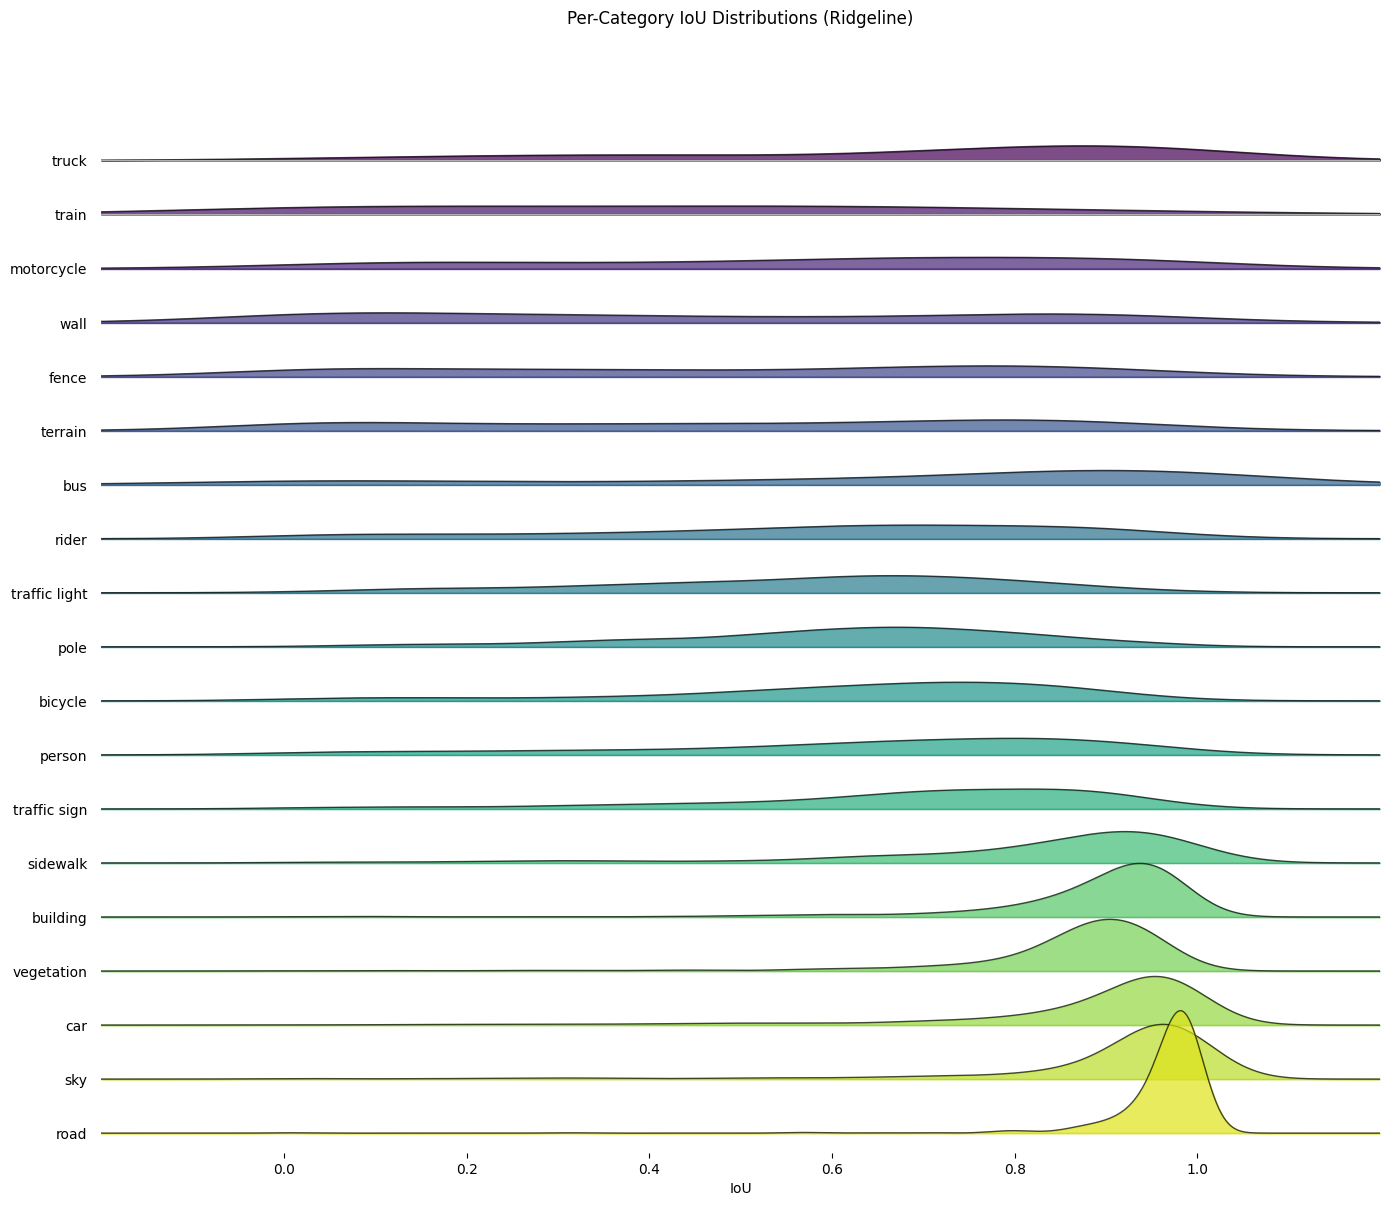

In [117]:
import joypy
import matplotlib.pyplot as plt

# Pivot long_df back to wide form for joypy
pivot_df = plot_df.pivot(columns='category', values='IoU')
norm_df = pivot_df.apply(lambda s: (s - s.min()) / (s.max() - s.min()))

plt.figure(figsize=(10, 12))
joypy.joyplot(
    data=norm_df,
    column=sorted_classes,
    labels=sorted_classes,
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(14, 12),
    title="Distribution of Per-Image IoU by Class (NaNs removed correctly)",
    colormap=plt.cm.viridis,
    alpha=0.7,
    overlap=1.4,
)
# joypy.joyplot(
#     pivot_df,
#     column=sorted_classes,
#     labels=sorted_classes,
#     kind="kde",
#     range_style="own",
#     bw_method=0.3,     # ← try values 0.1–0.3 for smoothness
#     linewidth=1,
#     colormap=plt.cm.viridis,
#     overlap=1.4,
# )
plt.title("Per-Category IoU Distributions (Ridgeline)")
plt.xlabel("IoU")
plt.show()

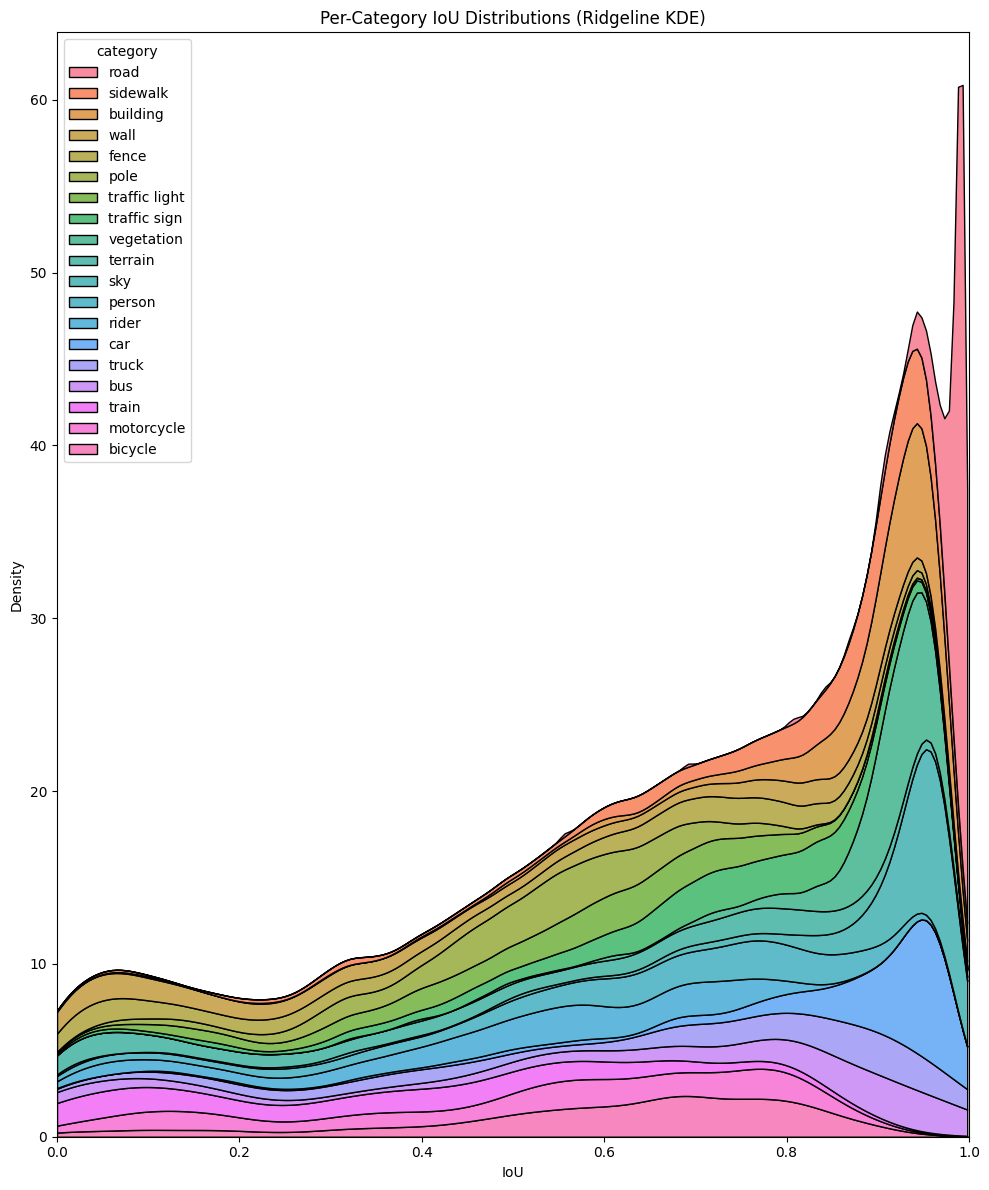

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

sns.kdeplot(
    data=plot_df,
    x="IoU",
    hue="category",
    fill=True,
    alpha=0.8,
    linewidth=1,
    multiple="stack",
    common_norm=False,
    bw_adjust=0.5,
    cut=0
)

plt.xlim(0, 1)
plt.title("Per-Category IoU Distributions (Ridgeline KDE)")
plt.xlabel("IoU")
plt.tight_layout()
plt.show()

In [119]:
# Construct a filename based on the model class name
model_name = current_model.__class__.__name__
csv_filename = f"{model_name}_per_image_iou.csv"
save_path = CITYSCAPES_ROOT / "benchmark_results" / csv_filename

# Ensure directory exists
save_path.parent.mkdir(parents=True, exist_ok=True)

# Save
per_image_iou_df.to_csv(save_path, index=False)
print(f"Saved per-image IoU stats to: {save_path}")

Saved per-image IoU stats to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/benchmark_results/SegFormerSAM3Wrapper_per_image_iou.csv
